# Packages

In [1]:
import pandas as pd
import numpy as np
import random
import os
from datatable import fread

import torch
import torch.nn.functional as F
from torch                    import nn
from torch.optim              import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from skorch                   import NeuralNetClassifier
from skorch.callbacks         import LRScheduler
from skorch.helper            import DataFrameTransformer

# Import

In [2]:
#Data directory
datadir = 'data/'

#Import mouse voxelwise data to use for training
file_voxel = "MouseExpressionMatrix_voxel_coronal_maskcoronal_log2_grouped_imputed_labelled_scaled.csv"
filepath_voxel = os.path.join(datadir, file_voxel)

#Import expression matrix
dfExprVoxel = (fread(filepath_voxel, header = True)
               .to_pandas())

# Data preparation

Let's start by sampling a subset of voxels. Ultimately this isn't necessary, but the methods used for feature importance take some time to run, so as a proof of concept we'll use fewer data points.

In [3]:
#Sample some observations for training
dfExprVoxel = dfExprVoxel.sample(n = 10000, axis = 0, random_state = 1).copy()

Next we prepare the data for training, mainly by separating labels and inputs, and converting to numpy arrays.

In [4]:
#Sample 5000 observations for training
dfExprVoxel = dfExprVoxel.sample(n = 10000, axis = 0, random_state = 1).copy()

#Identify which columns contain labels
indLabels = dfExprVoxel.columns.str.match('Region')

#Extract matrix of gene expression values
dfInput = dfExprVoxel.loc[:,~indLabels]

#Column containing training labels
labelcol = 'Region67'

#Create a new data frame containing training labels
dfLabels = dfExprVoxel[[labelcol]].copy()

#Convert labels to category type
dfLabels.loc[:,labelcol] = dfLabels.loc[:,labelcol].astype('category')

# Create an instance of the data transformer
dftx = DataFrameTransformer()

# Fit and transform the input and label data frames
X_temp = dftx.fit_transform(dfInput)
y_temp = dftx.fit_transform(dfLabels)

# Extract the arrays from the dictionaries.
X = X_temp['X']
y = y_temp[labelcol]

# Training the network

First we specify some of the hyperparameters of the perceptron.

In [5]:
#Specify network parameters
hidden_units = 200
weight_decay = 1e-6
max_epochs = 200
learning_rate = 1e-5
device = 'cpu'
seed = 1

Next, define the architecture of neural network, and initialize an instance of it with the desired number of input units, hidden units, and output units.

In [6]:
#Set seed
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

#Define network architecture
class ClassifierModule(nn.Module):
    def __init__(
        self,
        input_units,
        output_units,
        hidden_units,
        apply_output_layer = True #Flag to apply output layer
    ):
        super(ClassifierModule, self).__init__()

        self.apply_output_layer = apply_output_layer

        self.hidden1 = nn.Linear(input_units, hidden_units)
        self.hidden2 = nn.Linear(hidden_units, hidden_units)
        self.hidden3 = nn.Linear(hidden_units, hidden_units)
        self.output = nn.Linear(hidden_units, output_units)


    def forward(self, X, **kwargs):
        X = F.relu(self.hidden1(X))
        X = F.relu(self.hidden2(X))
        X = F.relu(self.hidden3(X))

        #If flag is True, apply output layer
        if self.apply_output_layer is True:
            X = F.softmax(self.output(X), dim = -1)

        return X

#Initialize network class with desired architecture
my_network = ClassifierModule(input_units = X.shape[1],
                              output_units = len(np.unique(y)),
                              hidden_units = hidden_units)
    

With the architecture specified, we now specify the optimization routine.

In [7]:
#Specify the optimization routine
net = NeuralNetClassifier(my_network,
                          train_split = None,
                          optimizer = AdamW,
                          optimizer__weight_decay = weight_decay,
                          max_epochs = max_epochs,
                          callbacks = [('lr_scheduler',
                                        LRScheduler(policy=OneCycleLR,
                                                    total_steps=max_epochs,
                                                    cycle_momentum=False,  
                                                    max_lr=learning_rate))],
                          device = device)

And finally we can fit the model.

In [8]:
#Train the network
net.fit(X, y)

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        4.2006  0.0000  0.3429
      2        4.1990  0.0000  0.2499
      3        4.1974  0.0000  0.2498
      4        4.1957  0.0000  0.2505
      5        4.1938  0.0000  0.2723
      6        4.1917  0.0000  0.2514
      7        4.1893  0.0000  0.2507
      8        4.1865  0.0000  0.2681
      9        4.1833  0.0000  0.2519
     10        4.1794  0.0000  0.2519
     11        4.1749  0.0000  0.2517
     12        4.1694  0.0000  0.2518
     13        4.1627  0.0000  0.2524
     14        4.1544  0.0000  0.2567
     15        4.1441  0.0000  0.2550
     16        4.1310  0.0000  0.2531
     17        4.1143  0.0000  0.2523
     18        4.0927  0.0000  0.2574
     19        4.0648  0.0000  0.2553
     20        4.0282  0.0000  0.2520
     21        3.9801  0.0000  0.2518
     22        3.9165  0.0000  0.2551
     23        3.8330  0.0000  0.2564
     24        3.7268  0.0000  0.2569
     25     

    174        0.2893  0.0000  0.2716
    175        0.2891  0.0000  0.2718
    176        0.2888  0.0000  0.2677
    177        0.2886  0.0000  0.2704
    178        0.2884  0.0000  0.2675
    179        0.2882  0.0000  0.2680
    180        0.2880  0.0000  0.2673
    181        0.2879  0.0000  0.2674
    182        0.2877  0.0000  0.2681
    183        0.2876  0.0000  0.2687
    184        0.2875  0.0000  0.2682
    185        0.2874  0.0000  0.2673
    186        0.2873  0.0000  0.2680
    187        0.2872  0.0000  0.2679
    188        0.2871  0.0000  0.2752
    189        0.2871  0.0000  0.2680
    190        0.2870  0.0000  0.2683
    191        0.2870  0.0000  0.2699
    192        0.2869  0.0000  0.2710
    193        0.2869  0.0000  0.2733
    194        0.2869  0.0000  0.2710
    195        0.2869  0.0000  0.2687
    196        0.2869  0.0000  0.2724
    197        0.2868  0.0000  0.2702
    198        0.2868  0.0000  0.2697
    199        0.2868  0.0000  0.2716
    200     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (hidden1): Linear(in_features=2835, out_features=200, bias=True)
    (relu1): ReLU()
    (hidden2): Linear(in_features=200, out_features=200, bias=True)
    (relu2): ReLU()
    (hidden3): Linear(in_features=200, out_features=200, bias=True)
    (relu3): ReLU()
    (output): Linear(in_features=200, out_features=67, bias=True)
  ),
)

To confirm this is working as it should, let's compute the training accuracy:

In [9]:
#Convert input np array to torch tensor
X_tensor = torch.from_numpy(X).type(torch.FloatTensor)

#Apply network to input tensor to get output probabilities
y_prob = my_network(X_tensor).detach().numpy()

#Classify using most likely label
y_pred = np.argmax(y_prob, axis = 1)

#Accuracy
sum(y_pred == y)/len(y)

0.9185

# Identifying feature importance using integrated gradients

The first method introduced in the Captum tutorial for feature importance is called "integrated gradients". I don't know what this is, but it seems like it returns some values for each of the inputs corresponding to a given output label.

In [10]:
from captum.attr import IntegratedGradients

We need to specify what label we want to examine, so let's look at our dictionary

In [11]:
dfLabels['y'] = y
dfLabels.drop_duplicates()

,Region67,y
41104,Culmen,13
6127,Pons,46
18253,Olfactory areas-other,37
33205,Caudoputamen,4
14311,Ectorhinal area,17
...,...,...
42787,Declive (VI),14
29782,Agranular insular area,1
18116,Claustrum,7
9770,Midbrain raphe nuclei,34


Let's start by examining the classification of caudoputamen voxels.

In [15]:
#Structure we want to examine
target_struct = 'Caudoputamen'

#Associated dummy label
target_label = int(dfLabels
                .loc[dfLabels['Region67'] == target_struct, ['y']]
                .drop_duplicates()
                .values[0][0])

To use integrated gradients, we first instantiate the relevant class, with our network architecture as input. We then apply the "attribute" method, here specifying the label that we want to examine.

In [16]:
#Set up an integrated gradients class
ig = IntegratedGradients(my_network)

#Compute the attributes tensor for the desired target label
X_tensor.requires_grad_()
attr = ig.attribute(X_tensor, 
                    target = target_label, 
                    internal_batch_size = X.shape[0])

#Convert to numpy array
attr = attr.detach().numpy()

It's unclear to me what this output is, but let's at least examine the shape of it.

In [14]:
print(attr.shape)

(10000, 2624)


So this thing has the same shape as the input data, meaning rows corresponding to observations and columns to predictors. This gives us one value for each cell entry in our input matrix. Unclear what exactly those values mean...

In the Captum tutorial, they take averages over the observations for each of the input features. Let's do that here. We're also going to sort the average values to see which features are most "important".

In [17]:
#Grab the set of genes
genes = dfInput.columns.to_numpy()

#Array of x values for plotting
x_pos = np.arange(len(genes))

#Mean integrated gradient attributes over all 
#observations for each feature
attr_mean = np.mean(attr, axis = 0)

#Sorted attributes
attr_mean_sorted, genes_sorted = zip(*sorted(zip(attr_mean, genes)))

Now that we have these average feature importances corresponding to classification of the caudoputamen, let's plot them. 

Text(0.5, 0, 'Gene')

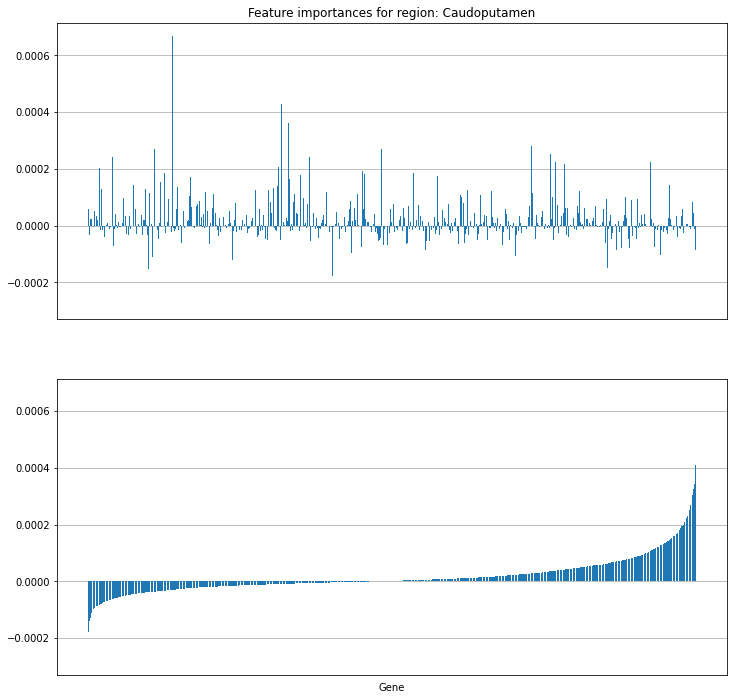

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize = (12,12))

axes[0].grid(zorder = 0, axis = 'y')
axes[0].bar(x_pos, attr_mean, zorder = 2)
axes[0].set_xticks([])
axes[0].set_title('Feature importances for region: {}'.format(target_struct))

axes[1].grid(zorder = 0, axis = 'y')
axes[1].bar(x_pos, attr_mean_sorted, align = 'center', zorder = 2)
axes[1].set_xticks([])
axes[1].set_xlabel('Gene')

Not super informative at this scale since there are so many inputs, but let's zoom in to take a look at what genes have the high attribute values.

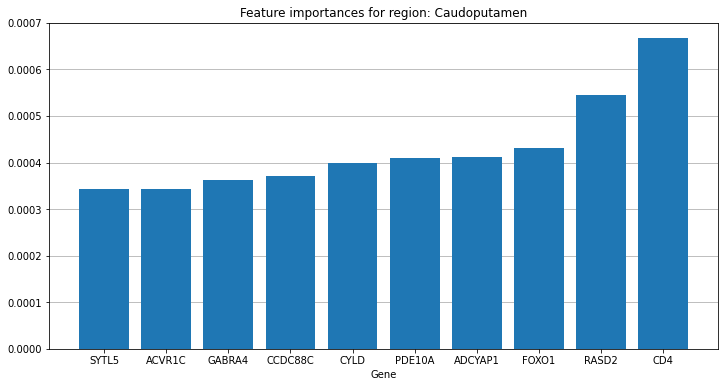

In [17]:
fig, ax = plt.subplots(figsize = (12,6))
ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos[-10:], attr_mean_sorted[-10:], align = 'center', zorder = 2)
ax.set_xticks(x_pos[-10:], genes_sorted[-10:])
ax.set_xlabel('Gene')
ax.set_title('Feature importances for region: {}'.format(target_struct))
plt.show()

Looks like CD4 is the most importance feature, followed by RASD2. What do these gene maps look like?

In [18]:
from pyminc.volumes.factory import volumeFromFile

#Anatomy and mask files
maskfile = 'AMBA/data/imaging/coronal_200um_coverage_bin0.8.mnc'
anatfile = 'AMBA/data/imaging/DSURQE_CCFv3_average_200um.mnc'

#Import volumes
mask = volumeFromFile(maskfile)
anat = volumeFromFile(anatfile)

#Convert to numpy
mask = np.array(mask.data)
anat = np.array(anat.data)

#Mask anatomy 
anat[mask == 0] = np.nan

In [19]:
#ISH files for genes mentioned above
exprfile1 = 'AMBA/data/expression/coronal/Cd4_74819249.mnc'
exprfile2 = 'AMBA/data/expression/coronal/Rasd2_73636089.mnc'

#Import
expr1 = volumeFromFile(exprfile1)
expr2 = volumeFromFile(exprfile2)

#Convert to numpy
expr1 = np.array(expr1.data)
expr2 = np.array(expr2.data)

#Mask
expr1[mask == 0] = np.nan
expr2[mask == 0] = np.nan

Text(0.5, 1.0, 'AMBA/data/expression/coronal/Rasd2_73636089.mnc')

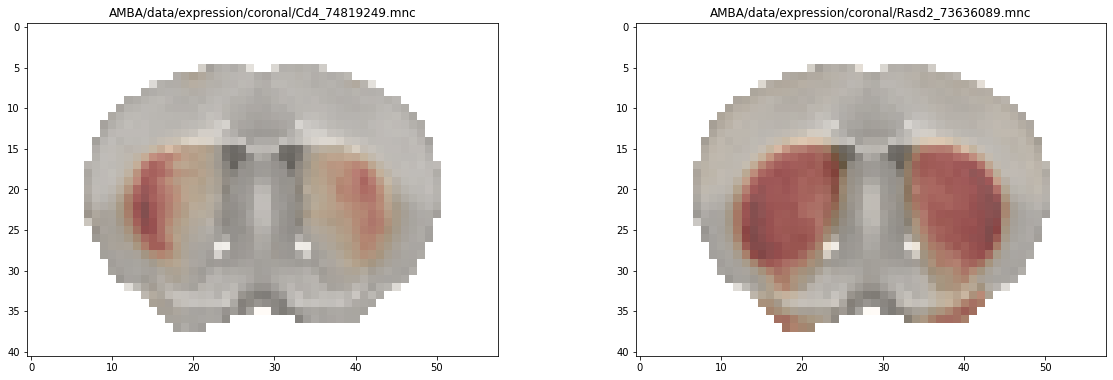

In [20]:
slc = 42
asp = anat.shape[1]/anat.shape[0]

anat_slice = anat[:,slc,:]
expr1_slice = expr1[:,slc,:]
expr2_slice = expr2[:,slc,:]

anat_slice = np.flip(anat_slice, axis = 0)
expr1_slice = np.flip(expr1_slice, axis = 0)
expr2_slice = np.flip(expr2_slice, axis = 0)

fig, axes = plt.subplots(1, 2, figsize = (2*10, 10/asp))

axes[0].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[0].imshow(expr1_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[0].set_title(exprfile1)

axes[1].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[1].imshow(expr2_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[1].set_title(exprfile2)

The two genes with the largest "importances" based on the integrated gradients method seem to have expression profiles that are localized to the caudoputamen. 

We know from this project that the striatum has really strong gene expression similarity between the mouse and human. What about a region that isn't as obvious? Let's look at the primary motor area. 

In [28]:
target_struct = 'Primary motor area'
target_label = int(dfLabels
                .loc[dfLabels['Region67'] == target_struct, ['y']]
                .drop_duplicates()
                .values[0][0])

In [29]:
attr = ig.attribute(X_tensor, 
                    target = target_label, 
                    internal_batch_size = X.shape[0])

#Convert to numpy array
attr = attr.detach().numpy()

attr_mean = np.mean(attr, axis = 0)

In [30]:
x_pos = np.arange(len(genes))
attr_mean_sorted, genes_sorted = zip(*sorted(zip(attr_mean, genes)))

Text(0.5, 0, 'Gene')

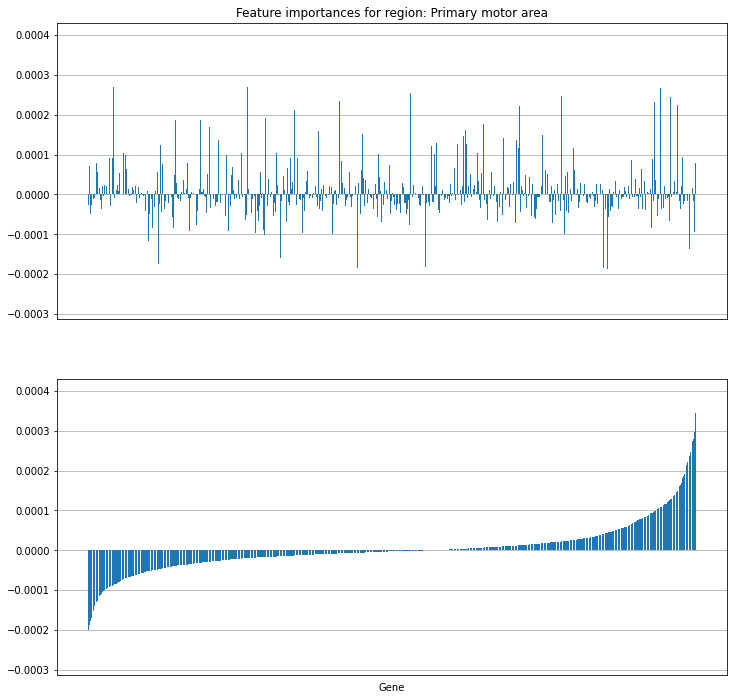

In [31]:
fig, axes = plt.subplots(2, 1, figsize = (12,12))

axes[0].grid(zorder = 0, axis = 'y')
axes[0].bar(x_pos, attr_mean, zorder = 2)
axes[0].set_xticks([])
axes[0].set_title('Feature importances for region: {}'.format(target_struct))

axes[1].grid(zorder = 0, axis = 'y')
axes[1].bar(x_pos, attr_mean_sorted, align = 'center', zorder = 2)
axes[1].set_xticks([])
axes[1].set_xlabel('Gene')

In this case, there isn't any one gene that is standing out above the rest. Regardless, what are the top genes here? 

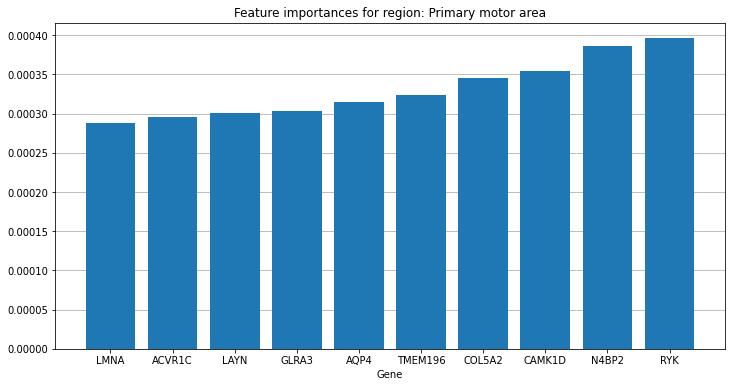

In [32]:
fig, ax = plt.subplots(figsize = (12,6))
ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos[-10:], attr_mean_sorted[-10:], align = 'center', zorder = 2)
ax.set_xticks(x_pos[-10:], genes_sorted[-10:])
ax.set_xlabel('Gene')
ax.set_title('Feature importances for region: {}'.format(target_struct))
plt.show()

More of a plateau here, but with 10,000 input observations, we find that RYK and N4BP2 are the top genes.

What do these look like? 

In [33]:
exprfile1 = 'AMBA/data/expression/coronal/Ryk_2541.mnc'
exprfile2 = 'AMBA/data/expression/coronal/N4bp2_74363354.mnc'

expr1 = volumeFromFile(exprfile1)
expr2 = volumeFromFile(exprfile2)

expr1 = np.array(expr1.data)
expr2 = np.array(expr2.data)

expr1[mask == 0] = np.nan
expr2[mask == 0] = np.nan

Text(0.5, 1.0, 'AMBA/data/expression/coronal/N4bp2_74363354.mnc')

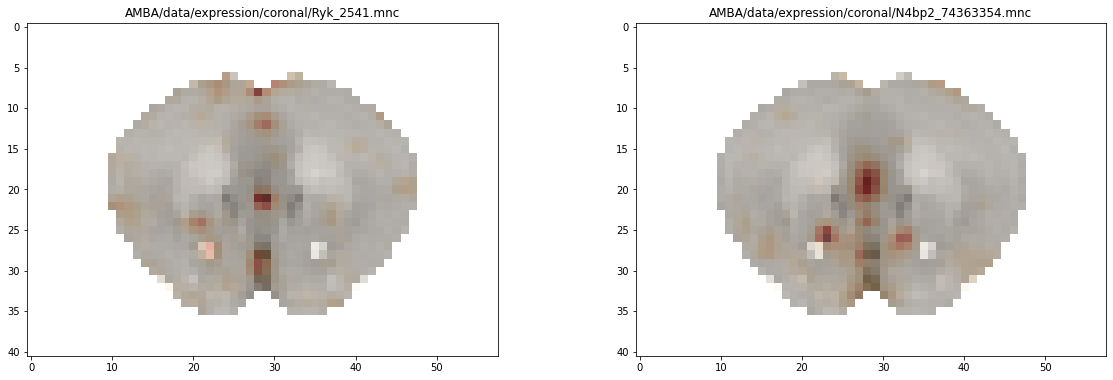

In [34]:
slc = 47

anat_slice = anat[:,slc,:]
expr1_slice = expr1[:,slc,:]
expr2_slice = expr2[:,slc,:]

anat_slice = np.flip(anat_slice, axis = 0)
expr1_slice = np.flip(expr1_slice, axis = 0)
expr2_slice = np.flip(expr2_slice, axis = 0)

fig, axes = plt.subplots(1, 2, figsize = (2*10, 10/asp))

axes[0].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[0].imshow(expr1_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[0].set_title(exprfile1)

axes[1].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[1].imshow(expr2_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[1].set_title(exprfile2)

Unclear how this relates to M1. Would need a better slice series. This is also probably a regime where we don't have a small set of genes contributing to the classification. 